# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [50]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import imutils

## Parameters

In [51]:
imagePath = "./Brieferstellung/test1.png"
# Kernel
blurring = 0
dilateErode = 15
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode-1,dilateErode), "uint8")
# 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [2.0,2.2]
stampZone = [74,40]
margin = 15
stampMinSize=[20,26]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

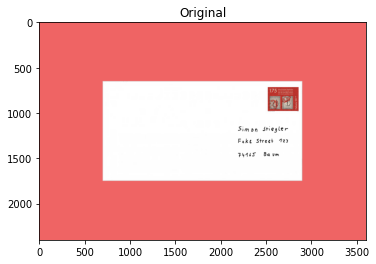

In [52]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")

## For Rotating the Picture
https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

In [53]:
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the image file")
# args, unknown =  ap.parse_args(argv[1:])

Text(0.5, 1.0, 'blurred')

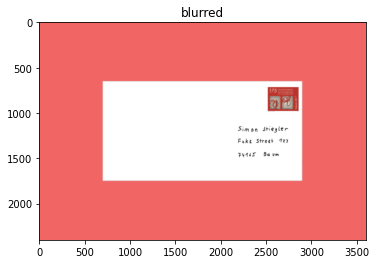

In [54]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image, (blurring,blurring) , 2, 2,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

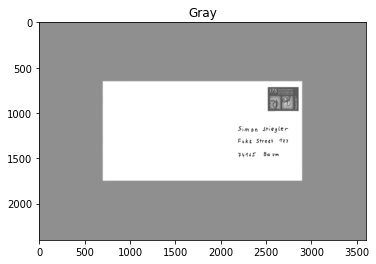

In [55]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

Text(0.5, 1.0, 'Canny')

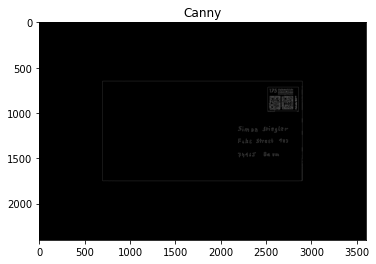

In [56]:
canny = cv2.Canny(gray,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

Text(0.5, 1.0, 'dilate')

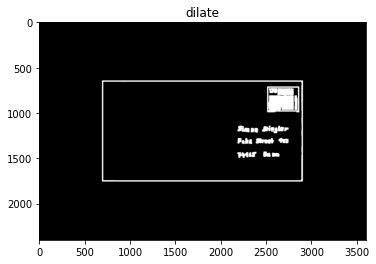

In [57]:
dilate = cv2.dilate(canny,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("dilate")

Text(0.5, 1.0, 'erode')

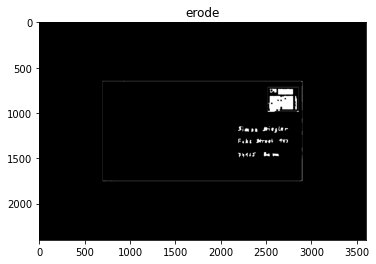

In [58]:
erode = cv2.erode(dilate,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("erode")

In [59]:
img,contours,hierachy = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [60]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

13178
13176
4368
2458
1250
674


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [61]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(contours):
    for contour in contours:
    #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        width = minArea[1][0]
        height = minArea[1][1]
        scale = width/height
        if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]):
            letter = {
                "width": int(width),
                "height" : int(height),
                "centerX" : int(minArea[0][0]),
                "centerY" : int(minArea[0][1]),
                "contour": contour
                }
            return letter

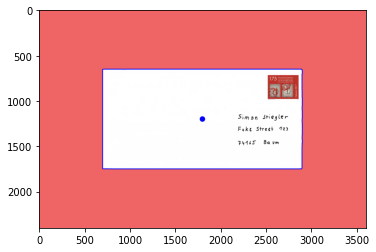

In [62]:
letterValue = findLetter(contours)
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = showImage.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (0, 0, 255), 7) 
plt.imshow(highlightedContour)

## ROI of Letter

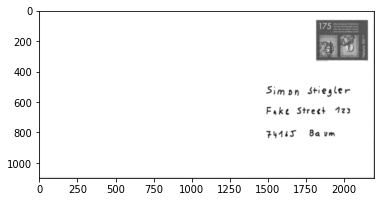

In [63]:
xStart = int(letterValue["centerX"]-letterValue["width"]/2)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2)
yStart = int(letterValue["centerY"]-letterValue["height"]/2)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2)
letter = gray[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")

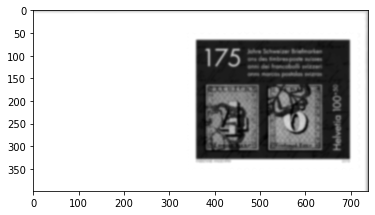

In [64]:
pixelPerMM = letterValue["width"]/C_5_6_Metrics[0]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")

### Check if stamp is there

In [65]:
def checkStamp(img):
    imgStamp,cStamp,hStamp = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for index,contour in enumerate(cStamp):
        #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        height = int(minArea[1][1])
        width = int(minArea[1][0])
        # stamp minSize 22x28
        contourWidth = width/pixelPerMM
        contourHeigth =height/pixelPerMM
        if(contourWidth>stampMinSize[0] and contourHeigth>stampMinSize[1]):
            print(True)

In [66]:
stamp = checkStamp(rightTop)

True


## Get AddressField

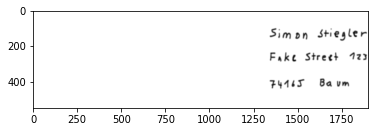

In [71]:
height, width = letter.shape
pixelMargin = margin*pixelPerMM
addressField = letter.copy()
startX = int(pixelMargin)
endX = int(width-pixelMargin)
startY = int(stampZone[1]*pixelPerMM)
endY = int(height-pixelMargin)
addressField = addressField[startY:endY,startX:endX]
plt.imshow(addressField, cmap="gray")

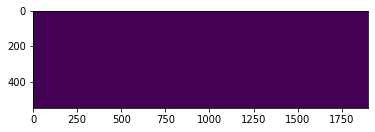

In [80]:
cannyAF = cv2.Canny(addressField,0,30)
imgAF,contoursAF,hierachyAF = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
plt.imshow(imgAF,cmap="gray")
contourImg = np.zeros((cannyAF.shape))
cv2.drawContours(,contoursAF , -1, (0, 0, 255), 7) 
plt.imshow(contourImg)

In [75]:
imgAF,contoursAF,hierachyAF = cv2.findContours(cannyAF,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


In [68]:
# # cutting the edges
# angle = 30
# # M = cv2.getRotationMatrix2D((int(width/2),int(height/2)), angle, 1)
# # rotatedLetter = cv2.warpAffine(showImage,M,(width,height))
# # plt.imshow(rotatedLetter)
# rotated = imutils.rotate_bound(showImage, angle)
# cv2.imshow("Rotated (Correct)", rotated)


### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [69]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

In [70]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()